# Notebook 3: Trajectory Integration for Walking Data

This notebook integrates FicTrac wheel rotation/displacement data with STAC-registered
joint angles to create complete walking trajectories with proper body position and orientation.

**Workflow:**
1. Load STAC IK output from Notebook 2
2. Load FicTrac trajectory data from original CSV
3. Calculate yaw orientation from trajectory direction
4. Apply position and orientation offsets to qpos
5. Optionally interpolate to higher frequency
6. Export final trajectory-integrated data

## 1. Environment Setup and Imports

In [1]:
# Environment setup (must be before JAX import)
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["XLA_FLAGS"] = "--xla_gpu_triton_gemm_any=True"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Adjust GPU as needed

In [2]:
%load_ext autoreload
%autoreload 2

# Standard library
import sys
import warnings
from pathlib import Path

# Scientific computing
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import jit, vmap
from scipy import interpolate

# MuJoCo
import mujoco

# Visualization
import matplotlib.pyplot as plt

# Progress bars
from tqdm.auto import tqdm

# H5 file I/O
import h5py

# JAX cache setup
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

print(f"JAX devices: {jax.devices()}")

/home/talmolab/Desktop/SalkResearch/mimic-mjx/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


JAX devices: [CudaDevice(id=0)]


## 2. Configuration

In [3]:
# === PATH CONFIGURATION ===
BASE_PATH = Path("/home/talmolab/Desktop/SalkResearch")
DATA_PATH = BASE_PATH / "data"
STAC_MJX_PATH = BASE_PATH / "stac-mjx"

# Input: STAC IK output from Notebook 2
STAC_IK_PATH = DATA_PATH / "stac_ik_output_tethered_fly.h5"

# Input: Original CSV for FicTrac data
CSV_DATA_PATH = DATA_PATH / "wt_berlin_tethered_dataset.csv"

# Input: Aligned keypoints (for clip mapping)
ALIGNED_KP_PATH = DATA_PATH / "aligned_walking_keypoints.h5"

# Model path (for wing joint indices)
MODEL_PATH = STAC_MJX_PATH / "models" / "fruitfly" / "fruitfly_force.xml"

# Output path
OUTPUT_PATH = DATA_PATH / "walking_trajectory_integrated.h5"

# === PROCESSING PARAMETERS ===
SMOOTHING_WINDOW = 75  # Window size for yaw smoothing
Z_OFFSET = 0.0195  # Height offset for z position

# Frequency settings
# FicTrac data is at 300Hz, STAC IK output was upsampled to 500Hz in Notebook 2
FICTRAC_SOURCE_HZ = 300  # FicTrac data frequency (from CSV)
STAC_OUTPUT_HZ = 500  # STAC IK output frequency (after interpolation in Notebook 2)

# Default wing position (folded wings)
DEFAULT_WING_POS = jnp.array([1.5, 0.814, -0.821, 1.5, 0.814, -0.821])

print(f"STAC IK input: {STAC_IK_PATH}")
print(f"CSV data: {CSV_DATA_PATH}")
print(f"Output: {OUTPUT_PATH}")
print(f"FicTrac source Hz: {FICTRAC_SOURCE_HZ}")
print(f"STAC output Hz: {STAC_OUTPUT_HZ}")

STAC IK input: /home/talmolab/Desktop/SalkResearch/data/stac_ik_output_tethered_fly.h5
CSV data: /home/talmolab/Desktop/SalkResearch/data/wt_berlin_tethered_dataset.csv
Output: /home/talmolab/Desktop/SalkResearch/data/walking_trajectory_integrated.h5
FicTrac source Hz: 300
STAC output Hz: 500


## 3. Load STAC IK Output

In [4]:
# Load STAC IK results from Notebook 2
print(f"Loading STAC IK output from {STAC_IK_PATH}...")

with h5py.File(STAC_IK_PATH, "r") as f:
    print(f"Attributes: {dict(f.attrs)}")

    # Load qpos (joint positions)
    qpos_all = f["qpos"][:]
    print(f"qpos shape: {qpos_all.shape}")

    # Load clip lengths
    clip_lengths = f["clip_lengths"][:]
    print(f"Number of clips: {len(clip_lengths)}")

    # Load other data if available
    xpos_all = f["xpos"][:] if "xpos" in f else None
    xquat_all = f["xquat"][:] if "xquat" in f else None
    offsets = f["offsets"][:] if "offsets" in f else None

    # Load names
    joint_names = (
        [n.decode("utf-8") for n in f["joint_names"][:]] if "joint_names" in f else None
    )
    kp_names = (
        [n.decode("utf-8") for n in f["kp_names"][:]] if "kp_names" in f else None
    )

print(f"\nTotal frames: {qpos_all.shape[0]}")
print(f"qpos dimensions: {qpos_all.shape[1]}")

Loading STAC IK output from /home/talmolab/Desktop/SalkResearch/data/stac_ik_output_tethered_fly.h5...
Attributes: {'output_hz': np.int64(500), 'source_hz': np.int64(300)}
qpos shape: (692115, 43)
Number of clips: 2713

Total frames: 692115
qpos dimensions: 43


In [5]:
# Reshape qpos into clips based on clip_lengths
qpos_clips = []
start_idx = 0

for clip_len in clip_lengths:
    end_idx = start_idx + clip_len
    qpos_clips.append(qpos_all[start_idx:end_idx])
    start_idx = end_idx

print(f"Split into {len(qpos_clips)} clips")
print(f"Clip length range: {min(clip_lengths)} - {max(clip_lengths)}")

Split into 2713 clips
Clip length range: 81 - 961


## 4. Load FicTrac Trajectory Data

In [6]:
# Load the original CSV to get FicTrac data
print(f"Loading FicTrac data from {CSV_DATA_PATH}...")
full_df = pd.read_csv(CSV_DATA_PATH)
print(f"Loaded dataframe with shape: {full_df.shape}")

# Check for FicTrac columns
fictrac_cols = [col for col in full_df.columns if "fictrac" in col.lower()]
print(f"\nFound {len(fictrac_cols)} FicTrac columns:")
for col in fictrac_cols[:10]:
    print(f"  - {col}")
if len(fictrac_cols) > 10:
    print(f"  ... and {len(fictrac_cols) - 10} more")

Loading FicTrac data from /home/talmolab/Desktop/SalkResearch/data/wt_berlin_tethered_dataset.csv...


/tmp/ipykernel_1413952/651314816.py:3: DtypeWarning: Columns (113,115,409,412,413) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(CSV_DATA_PATH)


Loaded dataframe with shape: (969650, 574)

Found 35 FicTrac columns:
  - fictrac_frame_counter
  - fictrac_delta_rot_cam_x
  - fictrac_delta_rot_cam_y
  - fictrac_delta_rot_cam_z
  - fictrac_delta_rot_score
  - fictrac_delta_rot_lab_x
  - fictrac_delta_rot_lab_y
  - fictrac_delta_rot_lab_z
  - fictrac_sphere_orientation_cam_x
  - fictrac_sphere_orientation_cam_y
  ... and 25 more


In [21]:
# Extract walking bouts and FicTrac trajectory data
all_bout_nums = full_df["walking_bout_number"].unique()
all_bout_nums = all_bout_nums[all_bout_nums > 0]  # Skip bout 0
all_bout_nums = sorted(all_bout_nums)

print(f"Found {len(all_bout_nums)} walking bouts")

# Extract trajectory data for each bout
int_x_cm = []  # Integrated X position in cm
int_y_cm = []  # Integrated Y position in cm
heading_deg = []  # Heading angle
bout_clip_lengths = []  # Actual bout lengths from CSV

for bout_num in tqdm(all_bout_nums, desc="Extracting FicTrac data"):
    bout = full_df[full_df["walking_bout_number"] == bout_num]
    bout_clip_lengths.append(len(bout))

    # Extract integrated position (convert mm to cm, swap axes for body model)
    # Note: Axes are swapped because the model coordinate system differs from FicTrac
    x_mm = bout["fictrac_int_y_mm"].values  # Swapped
    y_mm = bout["fictrac_int_x_mm"].values  # Swapped

    # Convert to cm and subtract initial position
    int_x_cm.append((x_mm / 10) - (x_mm[0] / 10))
    int_y_cm.append((y_mm / 10) - (y_mm[0] / 10))

    # Extract heading (subtract initial to get relative heading)
    heading = bout["fictrac_heading"].values
    heading_deg.append(heading - heading[0])

print(f"\nExtracted {len(int_x_cm)} trajectory clips")
print(f"Bout length range: {min(bout_clip_lengths)} - {max(bout_clip_lengths)}")

Found 2713 walking bouts


Extracting FicTrac data:   0%|          | 0/2713 [00:00<?, ?it/s]

Extracting FicTrac data: 100%|██████████| 2713/2713 [00:01<00:00, 1660.84it/s]


Extracted 2713 trajectory clips
Bout length range: 49 - 577


In [22]:
# Upsample FicTrac data from 300Hz to 500Hz to match STAC IK output
def interpolate_trajectory_1d(data, source_hz, target_hz):
    """Interpolate 1D trajectory data using cubic splines.

    Handles NaN values by linear interpolation before cubic spline fitting.
    """
    data = np.array(data, dtype=np.float64)
    T = len(data)
    duration = T / source_hz

    # Handle NaN values by linear interpolation
    if np.any(~np.isfinite(data)):
        # Get indices of valid and invalid values
        valid_mask = np.isfinite(data)
        if not np.any(valid_mask):
            # All NaN - return zeros
            T_new = int(np.round(duration * target_hz))
            return np.zeros(T_new)

        # Linear interpolation to fill NaN values
        valid_indices = np.where(valid_mask)[0]
        invalid_indices = np.where(~valid_mask)[0]
        data[invalid_indices] = np.interp(
            invalid_indices, valid_indices, data[valid_indices]
        )

    t_source = np.linspace(0, duration, T)
    T_new = int(np.round(duration * target_hz))
    t_target = np.linspace(0, duration, T_new)

    spline = interpolate.CubicSpline(t_source, data)
    return spline(t_target)


print(f"Upsampling FicTrac data from {FICTRAC_SOURCE_HZ}Hz to {STAC_OUTPUT_HZ}Hz...")

# Check for NaN values in original data
n_clips_with_nan = sum(1 for x in int_x_cm if np.any(~np.isfinite(x)))
if n_clips_with_nan > 0:
    print(f"Note: {n_clips_with_nan} clips contain NaN values (will be interpolated)")

int_x_cm_upsampled = []
int_y_cm_upsampled = []
heading_deg_upsampled = []

for i in tqdm(range(len(int_x_cm)), desc="Upsampling FicTrac"):
    int_x_cm_upsampled.append(
        interpolate_trajectory_1d(int_x_cm[i], FICTRAC_SOURCE_HZ, STAC_OUTPUT_HZ)
    )
    int_y_cm_upsampled.append(
        interpolate_trajectory_1d(int_y_cm[i], FICTRAC_SOURCE_HZ, STAC_OUTPUT_HZ)
    )
    heading_deg_upsampled.append(
        interpolate_trajectory_1d(heading_deg[i], FICTRAC_SOURCE_HZ, STAC_OUTPUT_HZ)
    )

# Replace original data with upsampled data
int_x_cm = int_x_cm_upsampled
int_y_cm = int_y_cm_upsampled
heading_deg = heading_deg_upsampled

print(f"Upsampling complete!")
print(
    f"Example: Clip 0 length: {bout_clip_lengths[0]} @ {FICTRAC_SOURCE_HZ}Hz -> {len(int_x_cm[0])} @ {STAC_OUTPUT_HZ}Hz"
)

Upsampling FicTrac data from 300Hz to 500Hz...
Note: 36 clips contain NaN values (will be interpolated)


Upsampling FicTrac:   8%|▊         | 222/2713 [00:00<00:01, 2209.50it/s]

Upsampling FicTrac: 100%|██████████| 2713/2713 [00:01<00:00, 2208.42it/s]

Upsampling complete!
Example: Clip 0 length: 469 @ 300Hz -> 782 @ 500Hz


In [23]:
# Verify clip counts and lengths match after upsampling
print(f"STAC IK clips: {len(qpos_clips)}")
print(f"FicTrac clips (upsampled): {len(int_x_cm)}")

if len(qpos_clips) != len(int_x_cm):
    print(f"WARNING: Clip count mismatch!")
    n_clips = min(len(qpos_clips), len(int_x_cm))
    print(f"Using first {n_clips} clips")
else:
    n_clips = len(qpos_clips)
    print("Clip counts match!")

# Verify lengths match for each clip (should now be much closer)
length_mismatches = []
for i in range(n_clips):
    qpos_len = len(qpos_clips[i])
    traj_len = len(int_x_cm[i])
    if abs(qpos_len - traj_len) > 2:  # Allow small rounding differences
        length_mismatches.append((i, qpos_len, traj_len))

if length_mismatches:
    print(
        f"\nFound {len(length_mismatches)} clips with significant length mismatches (>2 frames):"
    )
    for i, qlen, tlen in length_mismatches[:5]:
        print(f"  Clip {i}: qpos={qlen}, traj={tlen}, diff={qlen-tlen}")
    if len(length_mismatches) > 5:
        print(f"  ... and {len(length_mismatches) - 5} more")
else:
    print("\nAll clip lengths match (within rounding tolerance)!")

# Show a few examples
print(f"\nSample clip lengths:")
for i in range(min(5, n_clips)):
    print(f"  Clip {i}: qpos={len(qpos_clips[i])}, traj={len(int_x_cm[i])}")

STAC IK clips: 2713
FicTrac clips (upsampled): 2713
Clip counts match!

All clip lengths match (within rounding tolerance)!

Sample clip lengths:
  Clip 0: qpos=781, traj=782
  Clip 1: qpos=401, traj=402
  Clip 2: qpos=281, traj=282
  Clip 3: qpos=161, traj=162
  Clip 4: qpos=301, traj=302


## 5. Quaternion Utilities

Functions for quaternion operations (rotation, multiplication) needed for yaw integration.

In [24]:
def quat_rot_axis(axis, angle):
    """
    Create a quaternion representing rotation around an axis.

    Args:
        axis: (3,) rotation axis (should be normalized)
        angle: rotation angle in radians

    Returns:
        q: (4,) quaternion [w, x, y, z]
    """
    axis = axis / jnp.linalg.norm(axis)
    half_angle = angle / 2.0
    w = jnp.cos(half_angle)
    xyz = axis * jnp.sin(half_angle)
    return jnp.array([w, xyz[0], xyz[1], xyz[2]])


def quat_mul(q1, q2):
    """
    Multiply two quaternions.

    Args:
        q1: (4,) first quaternion [w, x, y, z]
        q2: (4,) second quaternion [w, x, y, z]

    Returns:
        q: (4,) result quaternion
    """
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2

    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2

    return jnp.array([w, x, y, z])


def normalize_quat(q):
    """
    Normalize a quaternion to unit length.
    """
    return q / jnp.linalg.norm(q)

## 6. Trajectory Processing Functions

In [25]:
def calculate_yaw_from_trajectory(int_x, int_y, smoothing_window=75):
    """
    Calculate smoothed yaw angles from trajectory position data.

    The yaw angle is computed from the direction of travel (velocity),
    then smoothed with a Gaussian kernel for natural transitions.

    Args:
        int_x: (T,) X position trajectory
        int_y: (T,) Y position trajectory
        smoothing_window: window size for Gaussian smoothing

    Returns:
        yaw_angles: (T,) smoothed yaw angles in radians
    """
    N = smoothing_window
    original_length = int_x.shape[0]

    # Calculate velocity using smoothed finite differences
    vel_window = 5
    pad_x = jnp.pad(int_x, vel_window // 2, mode="edge")
    pad_y = jnp.pad(int_y, vel_window // 2, mode="edge")

    # Smooth velocity calculation
    vel_x = jnp.convolve(
        jnp.diff(pad_x), jnp.ones(vel_window) / vel_window, mode="valid"
    )
    vel_y = jnp.convolve(
        jnp.diff(pad_y), jnp.ones(vel_window) / vel_window, mode="valid"
    )

    # Pad velocity to match original length
    current_length = vel_x.shape[0]
    pad_size = original_length - current_length
    pad_left = pad_size // 2
    pad_right = pad_size - pad_left
    vel_x = jnp.pad(vel_x, (pad_left, pad_right), mode="edge")
    vel_y = jnp.pad(vel_y, (pad_left, pad_right), mode="edge")

    # Calculate yaw from velocity direction
    dyaw_t = jnp.arctan2(vel_y, vel_x)

    # Unwrap to handle angle discontinuities
    unwrapped_yaw = jnp.unwrap(dyaw_t)

    # Gaussian smoothing kernel
    sigma = N / 6.0
    kernel_size = N + 1
    x = jnp.arange(-N // 2, N // 2 + 1)
    gaussian_kernel = jnp.exp(-0.5 * (x / sigma) ** 2)
    gaussian_kernel = gaussian_kernel / jnp.sum(gaussian_kernel)

    # Apply Gaussian smoothing
    pad_width = kernel_size // 2
    padded_yaw = jnp.pad(unwrapped_yaw, pad_width, mode="edge")
    smooth_yaw_conv = jnp.convolve(padded_yaw, gaussian_kernel, mode="valid")

    # Trim to original length
    diff = smooth_yaw_conv.shape[0] - original_length
    start = diff // 2
    smooth_yaw = jax.lax.dynamic_slice(smooth_yaw_conv, (start,), (original_length,))

    return smooth_yaw

In [26]:
def process_single_clip_trajectory(
    int_x_clip,
    int_y_clip,
    qpos_clip,
    wing_joint_idxs,
    default_wing_pos,
    smoothing_window=75,
    z_offset=0.0195,
):
    """
    Integrate trajectory data into a clip's qpos.

    Updates:
    - X, Y positions from FicTrac integrated trajectory
    - Z position adjusted by offset
    - Quaternion orientation updated with calculated yaw
    - Wing joints set to default (folded) position

    Args:
        int_x_clip: (T,) X trajectory positions in cm
        int_y_clip: (T,) Y trajectory positions in cm
        qpos_clip: (T, nq) joint positions from STAC
        wing_joint_idxs: indices of wing joints in qpos
        default_wing_pos: default wing joint positions
        smoothing_window: window for yaw smoothing
        z_offset: height offset for z position

    Returns:
        updated_qpos: (T, nq) qpos with integrated trajectory
    """
    # Calculate smoothed yaw from trajectory
    smooth_yaw = calculate_yaw_from_trajectory(int_x_clip, int_y_clip, smoothing_window)

    # Get initial quaternions from STAC output
    # qpos format: [x, y, z, qw, qx, qy, qz, joint1, joint2, ...]
    initial_quaternion = qpos_clip[:, 3:7]

    # Create yaw rotation quaternions (rotation around Z-axis)
    z_axis = jnp.array([0.0, 0.0, 1.0])
    yaw_quaternions = vmap(lambda angle: quat_rot_axis(z_axis, angle))(smooth_yaw)

    # Apply yaw rotation to initial orientation
    final_quaternions = vmap(quat_mul)(yaw_quaternions, initial_quaternion)

    # Normalize quaternions
    final_quaternions = vmap(normalize_quat)(final_quaternions)

    # Update qpos with trajectory data
    updated_qpos = qpos_clip.at[:, 0].set(int_x_clip)  # X position
    updated_qpos = updated_qpos.at[:, 1].set(int_y_clip)  # Y position
    updated_qpos = updated_qpos.at[:, 2].set(
        jnp.min(qpos_clip[:, 2]) - z_offset
    )  # Z position
    updated_qpos = updated_qpos.at[:, 3:7].set(final_quaternions)  # Quaternion

    # Set wing joints to default position
    if wing_joint_idxs is not None and len(wing_joint_idxs) > 0:
        for i, idx in enumerate(wing_joint_idxs):
            if i < len(default_wing_pos):
                updated_qpos = updated_qpos.at[:, idx].set(default_wing_pos[i])

    return updated_qpos


# JIT compile
jit_process_clip = jit(
    process_single_clip_trajectory, static_argnames=["smoothing_window"]
)

## 7. Get Wing Joint Indices

In [27]:
# Load model to find wing joint indices
print(f"Loading model from {MODEL_PATH}...")
spec = mujoco.MjSpec().from_file(str(MODEL_PATH))
mj_model = spec.compile()

# Find wing joints
wing_joint_names = [joint.name for joint in spec.joints if "wing" in joint.name.lower()]
print(f"Wing joints: {wing_joint_names}")

# Get joint indices in qpos
# Note: qpos includes root position (3) + quaternion (4) + joint angles
# So joint indices start at 7
all_joint_names = [joint.name for joint in spec.joints]
wing_joint_idxs = []

for wing_name in wing_joint_names:
    if wing_name in all_joint_names:
        # Find the index in joint list (excluding free joint if any)
        joint_idx = all_joint_names.index(wing_name)
        # Add offset for root position and quaternion
        qpos_idx = 7 + joint_idx  # 3 pos + 4 quat + joint index
        wing_joint_idxs.append(qpos_idx)
        print(f"  {wing_name}: joint_idx={joint_idx}, qpos_idx={qpos_idx}")

wing_joint_idxs = tuple(wing_joint_idxs) if wing_joint_idxs else None
print(f"\nWing joint qpos indices: {wing_joint_idxs}")

Loading model from /home/talmolab/Desktop/SalkResearch/stac-mjx/models/fruitfly/fruitfly_force.xml...
Wing joints: []

Wing joint qpos indices: None


## 8. Visualize Sample Trajectory

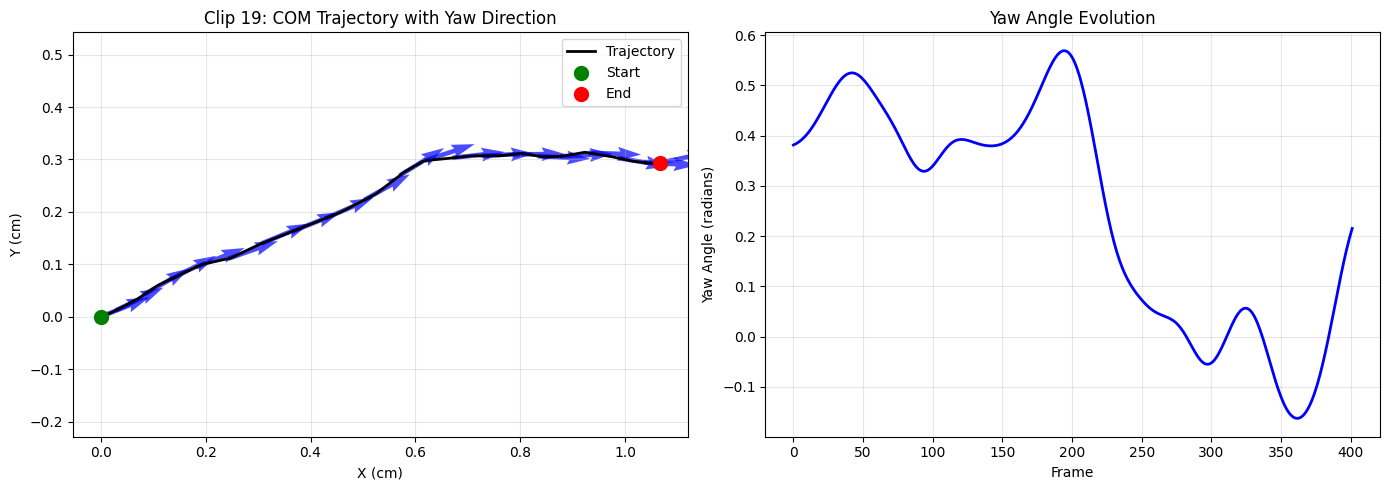

In [28]:
# Visualize a sample trajectory before processing
sample_idx = 19  # Change this to view different clips

if sample_idx < len(int_x_cm):
    x = int_x_cm[sample_idx]
    y = int_y_cm[sample_idx]

    # Calculate yaw for visualization
    test_yaw = np.array(
        calculate_yaw_from_trajectory(jnp.array(x), jnp.array(y), SMOOTHING_WINDOW)
    )

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot trajectory with yaw directions
    u = np.cos(test_yaw)
    v = np.sin(test_yaw)

    axes[0].plot(x, y, "k-", linewidth=2, label="Trajectory")
    axes[0].scatter(x[0], y[0], c="g", s=100, label="Start", zorder=5)
    axes[0].scatter(x[-1], y[-1], c="r", s=100, label="End", zorder=5)

    # Plot yaw direction arrows (every 10 frames)
    step = max(1, len(x) // 20)
    axes[0].quiver(
        x[::step],
        y[::step],
        u[::step],
        v[::step],
        angles="xy",
        scale_units="xy",
        scale=10,
        color="b",
        alpha=0.7,
    )

    axes[0].set_xlabel("X (cm)")
    axes[0].set_ylabel("Y (cm)")
    axes[0].set_title(f"Clip {sample_idx}: COM Trajectory with Yaw Direction")
    axes[0].axis("equal")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot yaw over time
    axes[1].plot(test_yaw, "b-", linewidth=2)
    axes[1].set_xlabel("Frame")
    axes[1].set_ylabel("Yaw Angle (radians)")
    axes[1].set_title("Yaw Angle Evolution")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print(f"Sample index {sample_idx} out of range (max: {len(int_x_cm)-1})")

In [31]:
# Process all clips with trajectory integration using batched vmap for speed
print(f"Processing {n_clips} clips with trajectory integration (batched)...")

# Find the minimum length for each clip pair (qpos vs trajectory)
clip_lengths_actual = []
for i in range(n_clips):
    min_len = min(len(int_x_cm[i]), len(qpos_clips[i]))
    clip_lengths_actual.append(min_len)

max_len = max(clip_lengths_actual)
print(f"Max clip length: {max_len}, Min: {min(clip_lengths_actual)}")

# Pad all clips to max_len for batched processing
print("Padding clips for batched processing...")
int_x_padded = np.zeros((n_clips, max_len))
int_y_padded = np.zeros((n_clips, max_len))
qpos_padded = np.zeros((n_clips, max_len, qpos_clips[0].shape[1]))

for i in range(n_clips):
    L = clip_lengths_actual[i]
    int_x_padded[i, :L] = int_x_cm[i][:L]
    int_y_padded[i, :L] = int_y_cm[i][:L]
    qpos_padded[i, :L] = qpos_clips[i][:L]
    # Pad with edge values to avoid discontinuities
    if L < max_len:
        int_x_padded[i, L:] = int_x_cm[i][L - 1]
        int_y_padded[i, L:] = int_y_cm[i][L - 1]
        qpos_padded[i, L:] = qpos_clips[i][L - 1]

# Convert to JAX arrays
int_x_jax = jnp.array(int_x_padded)
int_y_jax = jnp.array(int_y_padded)
qpos_jax = jnp.array(qpos_padded)

print(f"Batched arrays shape: int_x={int_x_jax.shape}, qpos={qpos_jax.shape}")


# Create vmapped version of processing function
def process_clip_for_vmap(int_x, int_y, qpos):
    """Wrapper for vmap - processes a single clip."""
    return process_single_clip_trajectory(
        int_x,
        int_y,
        qpos,
        wing_joint_idxs=wing_joint_idxs,
        default_wing_pos=DEFAULT_WING_POS,
        smoothing_window=SMOOTHING_WINDOW,
        z_offset=Z_OFFSET,
    )


# vmap over the batch dimension
vmap_process = jax.vmap(process_clip_for_vmap)

# JIT compile the vmapped function
jit_vmap_process = jax.jit(vmap_process)

# Process all clips in parallel
print("Running batched trajectory integration (this may take a moment to compile)...")
import time

start_time = time.time()

# Process in batches to avoid memory issues
BATCH_SIZE = 256  # Adjust based on GPU memory
processed_batches = []

for batch_start in tqdm(range(0, n_clips, BATCH_SIZE), desc="Processing batches"):
    batch_end = min(batch_start + BATCH_SIZE, n_clips)

    batch_result = jit_vmap_process(
        int_x_jax[batch_start:batch_end],
        int_y_jax[batch_start:batch_end],
        qpos_jax[batch_start:batch_end],
    )
    processed_batches.append(np.array(batch_result))

# Concatenate batches
all_processed = np.concatenate(processed_batches, axis=0)

elapsed = time.time() - start_time
print(f"Batched processing completed in {elapsed:.2f} seconds")

# Unpad to original lengths
processed_qpos = []
for i in range(n_clips):
    L = clip_lengths_actual[i]
    processed_qpos.append(all_processed[i, :L])

print(f"\nProcessed {len(processed_qpos)} clips")

Processing 2713 clips with trajectory integration (batched)...
Max clip length: 961, Min: 81
Padding clips for batched processing...


Batched arrays shape: int_x=(2713, 961), qpos=(2713, 961, 43)
Running batched trajectory integration (this may take a moment to compile)...


Processing batches: 100%|██████████| 11/11 [00:00<00:00, 41.85it/s]


Batched processing completed in 0.32 seconds

Processed 2713 clips


In [30]:
# Process all clips with trajectory integration
print(f"Processing {n_clips} clips with trajectory integration...")

processed_qpos = []

for clip_idx in tqdm(range(n_clips), desc="Integrating trajectories"):
    # Get data for this clip
    int_x = jnp.array(int_x_cm[clip_idx])
    int_y = jnp.array(int_y_cm[clip_idx])
    qpos = jnp.array(qpos_clips[clip_idx])

    # Handle length mismatch by truncating to minimum
    min_len = min(len(int_x), len(qpos))
    int_x = int_x[:min_len]
    int_y = int_y[:min_len]
    qpos = qpos[:min_len]

    # Process this clip
    updated_qpos = jit_process_clip(
        int_x,
        int_y,
        qpos,
        wing_joint_idxs,
        DEFAULT_WING_POS,
        smoothing_window=SMOOTHING_WINDOW,
        z_offset=Z_OFFSET,
    )

    processed_qpos.append(np.array(updated_qpos))

print(f"\nProcessed {len(processed_qpos)} clips")

Processing 2713 clips with trajectory integration...


Integrating trajectories:   1%|          | 14/2713 [00:03<11:28,  3.92it/s]


KeyboardInterrupt: 

## 10. Optional: Interpolate to Higher Frequency

In [ ]:
# The data is already at STAC_OUTPUT_HZ (500Hz) after upsampling FicTrac to match STAC IK output
# No further interpolation needed unless you want to change to a different frequency

FINAL_OUTPUT_HZ = STAC_OUTPUT_HZ  # Set to different value if you want to resample

if FINAL_OUTPUT_HZ != STAC_OUTPUT_HZ:
    print(f"Resampling from {STAC_OUTPUT_HZ}Hz to {FINAL_OUTPUT_HZ}Hz...")

    resampled_qpos = []
    new_clip_lengths = []

    for clip_idx, clip in enumerate(tqdm(processed_qpos, desc="Resampling")):
        resampled_clip = interpolate_clip(clip, STAC_OUTPUT_HZ, FINAL_OUTPUT_HZ)
        resampled_qpos.append(resampled_clip)
        new_clip_lengths.append(len(resampled_clip))

    final_qpos = resampled_qpos
    final_clip_lengths = new_clip_lengths
    output_hz = FINAL_OUTPUT_HZ

    print(f"Resampling complete!")
    print(f"Original total frames: {sum(len(c) for c in processed_qpos)}")
    print(f"Resampled total frames: {sum(final_clip_lengths)}")
else:
    print(f"No additional resampling needed (data already at {STAC_OUTPUT_HZ}Hz)")
    final_qpos = processed_qpos
    final_clip_lengths = [len(c) for c in processed_qpos]
    output_hz = STAC_OUTPUT_HZ

print(f"Final output frequency: {output_hz}Hz")

In [ ]:
if TARGET_HZ is not None and TARGET_HZ != SOURCE_HZ:
    print(f"Interpolating from {SOURCE_HZ}Hz to {TARGET_HZ}Hz...")

    interpolated_qpos = []
    new_clip_lengths = []

    for clip_idx, clip in enumerate(tqdm(processed_qpos, desc="Interpolating")):
        interp_clip = interpolate_clip(clip, SOURCE_HZ, TARGET_HZ)
        interpolated_qpos.append(interp_clip)
        new_clip_lengths.append(len(interp_clip))

    final_qpos = interpolated_qpos
    final_clip_lengths = new_clip_lengths
    output_hz = TARGET_HZ

    print(f"Interpolation complete!")
    print(f"Original total frames: {sum(len(c) for c in processed_qpos)}")
    print(f"Interpolated total frames: {sum(final_clip_lengths)}")
else:
    print(f"No interpolation (source={SOURCE_HZ}Hz, target={TARGET_HZ}Hz)")
    final_qpos = processed_qpos
    final_clip_lengths = [len(c) for c in processed_qpos]
    output_hz = SOURCE_HZ

In [32]:
final_qpos = processed_qpos

## 11.5 Render Trajectory Animation

Render the trajectory-integrated walking animation using MuJoCo.

In [33]:
# Check model structure - does it have a freejoint?
mj_model_check = mujoco.MjModel.from_xml_path(str(MODEL_PATH))
spec_check = mujoco.MjSpec().from_file(str(MODEL_PATH))

print("=== Model Joint Structure ===")
print(f"Model nq (qpos size): {mj_model_check.nq}")
print(f"Model nv (qvel size): {mj_model_check.nv}")

print(f"\nFirst 10 joints:")
for i, joint in enumerate(spec_check.joints[:10]):
    print(f"  {i}: {joint.name} (type={joint.type})")

# Check if first joint is freejoint
first_joint = spec_check.joints[0] if spec_check.joints else None
if first_joint:
    print(f"\nFirst joint name: '{first_joint.name}'")
    print(f"First joint type: {first_joint.type}")
    # Type 0 = free, Type 1 = ball, Type 2 = slide, Type 3 = hinge
    joint_type_names = {0: "FREE", 1: "BALL", 2: "SLIDE", 3: "HINGE"}
    print(f"Joint type meaning: {joint_type_names.get(first_joint.type, 'UNKNOWN')}")

    if first_joint.type == 0:  # FREE joint
        print(
            "\n✓ Model HAS a freejoint - qpos[0:3] should be position, qpos[3:7] should be quaternion"
        )
    else:
        print("\n✗ Model does NOT have a freejoint at the start!")
        print("  This means qpos[0:3] is NOT controlling position!")
        print("  The body position is likely fixed or controlled differently.")

=== Model Joint Structure ===
Model nq (qpos size): 43
Model nv (qvel size): 42

First 10 joints:
  0: free (type=mjtJoint.mjJNT_FREE)
  1: coxa_flexion_T1_left (type=mjtJoint.mjJNT_HINGE)
  2: coxa_twist_T1_left (type=mjtJoint.mjJNT_HINGE)
  3: femur_twist_T1_left (type=mjtJoint.mjJNT_HINGE)
  4: femur_T1_left (type=mjtJoint.mjJNT_HINGE)
  5: tibia_T1_left (type=mjtJoint.mjJNT_HINGE)
  6: tarsus_T1_left (type=mjtJoint.mjJNT_HINGE)
  7: coxa_flexion_T1_right (type=mjtJoint.mjJNT_HINGE)
  8: coxa_twist_T1_right (type=mjtJoint.mjJNT_HINGE)
  9: femur_twist_T1_right (type=mjtJoint.mjJNT_HINGE)

First joint name: 'free'
First joint type: mjtJoint.mjJNT_FREE
Joint type meaning: FREE

✓ Model HAS a freejoint - qpos[0:3] should be position, qpos[3:7] should be quaternion


In [34]:
# DEBUG: Verify qpos positions are being set correctly
sample_idx = 19
render_qpos = final_qpos[sample_idx]

print("=== DEBUG: Checking qpos position values ===")
print(f"Clip {sample_idx} shape: {render_qpos.shape}")
print(f"\nFirst frame qpos[0:7] (pos + quat):")
print(f"  Position (X,Y,Z): {render_qpos[0, 0:3]}")
print(f"  Quaternion: {render_qpos[0, 3:7]}")

print(f"\nLast frame qpos[0:7] (pos + quat):")
print(f"  Position (X,Y,Z): {render_qpos[-1, 0:3]}")
print(f"  Quaternion: {render_qpos[-1, 3:7]}")

print(f"\nPosition ranges:")
print(f"  X: [{render_qpos[:, 0].min():.4f}, {render_qpos[:, 0].max():.4f}]")
print(f"  Y: [{render_qpos[:, 1].min():.4f}, {render_qpos[:, 1].max():.4f}]")
print(f"  Z: [{render_qpos[:, 2].min():.4f}, {render_qpos[:, 2].max():.4f}]")

# Check if MuJoCo model nq matches
mj_model_test = mujoco.MjModel.from_xml_path(str(MODEL_PATH))
print(f"\nMuJoCo model nq: {mj_model_test.nq}")
print(f"qpos array size: {render_qpos.shape[1]}")

# Test setting qpos and checking what happens
mj_data_test = mujoco.MjData(mj_model_test)
mj_data_test.qpos[:] = render_qpos[0]
mujoco.mj_forward(mj_model_test, mj_data_test)

print(f"\nAfter mj_forward with first frame:")
print(f"  mj_data.qpos[0:3] (position): {mj_data_test.qpos[0:3]}")

mj_data_test.qpos[:] = render_qpos[-1]
mujoco.mj_forward(mj_model_test, mj_data_test)

print(f"\nAfter mj_forward with last frame:")
print(f"  mj_data.qpos[0:3] (position): {mj_data_test.qpos[0:3]}")

# Check body position (thorax) to see if it actually moved
print(f"\nThorax body position after forward:")
thorax_id = mujoco.mj_name2id(mj_model_test, mujoco.mjtObj.mjOBJ_BODY, "thorax")
print(f"  xpos[thorax]: {mj_data_test.xpos[thorax_id]}")

=== DEBUG: Checking qpos position values ===
Clip 19 shape: (401, 43)

First frame qpos[0:7] (pos + quat):
  Position (X,Y,Z): [ 0.          0.         -0.00455915]
  Quaternion: [ 0.9685564   0.02756371 -0.03167609  0.24522558]

Last frame qpos[0:7] (pos + quat):
  Position (X,Y,Z): [ 1.0655307   0.29341698 -0.00455915]
  Quaternion: [ 0.9985672  -0.02213673 -0.0424857   0.0238453 ]

Position ranges:
  X: [0.0000, 1.0655]
  Y: [0.0000, 0.3135]
  Z: [-0.0046, -0.0046]

MuJoCo model nq: 43
qpos array size: 43

After mj_forward with first frame:
  mj_data.qpos[0:3] (position): [ 0.          0.         -0.00455915]

After mj_forward with last frame:
  mj_data.qpos[0:3] (position): [ 1.06553066  0.29341698 -0.00455915]

Thorax body position after forward:
  xpos[thorax]: [ 1.06553066  0.29341698 -0.00455915]


In [35]:
# Render with FIXED camera to see global movement
import mediapy as media

RENDER_CLIP_IDX = 19
RENDER_FPS = 50
MAX_RENDER_FRAMES = 500

render_qpos = final_qpos[RENDER_CLIP_IDX]
n_frames = min(len(render_qpos), MAX_RENDER_FRAMES)

print(f"Rendering clip {RENDER_CLIP_IDX} with FIXED camera to see global movement")
print(
    f"Trajectory range: X=[{render_qpos[:, 0].min():.2f}, {render_qpos[:, 0].max():.2f}]"
)
print(
    f"                  Y=[{render_qpos[:, 1].min():.2f}, {render_qpos[:, 1].max():.2f}]"
)

# Load model
mj_model = mujoco.MjModel.from_xml_path(str(MODEL_PATH))
mj_data = mujoco.MjData(mj_model)

# Setup renderer
renderer = mujoco.Renderer(mj_model, width=800, height=600)

# Calculate fixed camera position to see entire trajectory
x_min, x_max = render_qpos[:n_frames, 0].min(), render_qpos[:n_frames, 0].max()
y_min, y_max = render_qpos[:n_frames, 1].min(), render_qpos[:n_frames, 1].max()
x_center = (x_min + x_max) / 2
y_center = (y_min + y_max) / 2
traj_extent = max(x_max - x_min, y_max - y_min)

# Create FIXED camera (not tracking)
camera = mujoco.MjvCamera()
camera.type = mujoco.mjtCamera.mjCAMERA_FREE
camera.lookat[:] = [x_center, y_center, 0]  # Look at center of trajectory
camera.distance = traj_extent + 1.0  # Far enough to see entire trajectory
camera.azimuth = 90
camera.elevation = -45  # Angled view

print(f"Camera looking at: ({x_center:.2f}, {y_center:.2f}, 0)")
print(f"Camera distance: {camera.distance:.2f}")

# Render frames
frames = []
for i in tqdm(range(n_frames), desc="Rendering fixed camera"):
    mj_data.qpos[:] = render_qpos[i, : mj_model.nq]
    mujoco.mj_forward(mj_model, mj_data)

    renderer.update_scene(mj_data, camera=camera)
    frame = renderer.render()
    frames.append(frame)

renderer.close()

print(f"Displaying animation with fixed camera...")
media.show_video(frames, fps=RENDER_FPS)

Rendering clip 19 with FIXED camera to see global movement
Trajectory range: X=[0.00, 1.07]
                  Y=[0.00, 0.31]
Camera looking at: (0.53, 0.16, 0)
Camera distance: 2.07


Rendering fixed camera: 100%|██████████| 401/401 [00:00<00:00, 576.15it/s]


Displaying animation with fixed camera...


In [36]:
# Render a sample trajectory-integrated clip
import mediapy as media

RENDER_CLIP_IDX = 19  # Which clip to render (change this to view different clips)
RENDER_FPS = 50  # Playback FPS (lower than actual for easier viewing)
MAX_RENDER_FRAMES = 1500  # Maximum frames to render

# Get the processed clip
if RENDER_CLIP_IDX < len(final_qpos):
    render_qpos = final_qpos[RENDER_CLIP_IDX]
    n_frames = min(len(render_qpos), MAX_RENDER_FRAMES)

    print(f"Rendering clip {RENDER_CLIP_IDX}: {n_frames} frames at {RENDER_FPS} FPS")
    print(
        f"Trajectory range: X=[{render_qpos[:, 0].min():.2f}, {render_qpos[:, 0].max():.2f}] cm"
    )
    print(
        f"                  Y=[{render_qpos[:, 1].min():.2f}, {render_qpos[:, 1].max():.2f}] cm"
    )

    # Load model for rendering
    mj_model = mujoco.MjModel.from_xml_path(str(MODEL_PATH))
    mj_data = mujoco.MjData(mj_model)

    # Setup renderer with larger resolution for better quality
    renderer = mujoco.Renderer(mj_model, width=800, height=600)

    # Render frames
    frames = []
    for i in tqdm(range(n_frames), desc="Rendering"):
        # Set qpos (convert position from cm to model units if needed)
        mj_data.qpos[:] = render_qpos[i,]
        mujoco.mj_forward(mj_model, mj_data)

        # Render with tracking camera
        renderer.update_scene(mj_data, camera="track1")
        frame = renderer.render()
        frames.append(frame)

    renderer.close()

    # Display as video
    print(f"Displaying animation ({len(frames)} frames)...")
    media.show_video(frames, fps=RENDER_FPS)
else:
    print(f"Clip index {RENDER_CLIP_IDX} out of range (max: {len(final_qpos)-1})")

Rendering clip 19: 401 frames at 50 FPS
Trajectory range: X=[0.00, 1.07] cm
                  Y=[0.00, 0.31] cm


Rendering: 100%|██████████| 401/401 [00:00<00:00, 555.87it/s]


Displaying animation (401 frames)...


In [ ]:
# Render top-down view showing the walking trajectory path
RENDER_TOPDOWN = True
TOPDOWN_CLIP_IDX = 19  # Same clip as above

if RENDER_TOPDOWN and TOPDOWN_CLIP_IDX < len(final_qpos):
    render_qpos = final_qpos[TOPDOWN_CLIP_IDX]
    n_frames = min(len(render_qpos), MAX_RENDER_FRAMES)

    print(f"Rendering top-down view of clip {TOPDOWN_CLIP_IDX}...")

    # Load model
    mj_model = mujoco.MjModel.from_xml_path(str(MODEL_PATH))
    mj_data = mujoco.MjData(mj_model)

    # Setup renderer
    renderer = mujoco.Renderer(mj_model, width=800, height=600)

    # Calculate camera position to track the trajectory
    x_range = render_qpos[:n_frames, 0].max() - render_qpos[:n_frames, 0].min()
    y_range = render_qpos[:n_frames, 1].max() - render_qpos[:n_frames, 1].min()
    x_center = (render_qpos[:n_frames, 0].max() + render_qpos[:n_frames, 0].min()) / 2
    y_center = (render_qpos[:n_frames, 1].max() + render_qpos[:n_frames, 1].min()) / 2

    # Camera height based on trajectory extent
    cam_height = max(x_range, y_range) * 1.5 + 0.5

    # Create custom camera for top-down view
    camera = mujoco.MjvCamera()
    camera.type = mujoco.mjtCamera.mjCAMERA_FREE
    camera.lookat[:] = [x_center, y_center, 0]
    camera.distance = cam_height
    camera.azimuth = 90  # Top-down
    camera.elevation = -90  # Looking straight down

    # Render frames
    frames_topdown = []
    for i in tqdm(range(n_frames), desc="Rendering top-down"):
        mj_data.qpos[:] = render_qpos[i, : mj_model.nq]
        mujoco.mj_forward(mj_model, mj_data)

        renderer.update_scene(mj_data, camera=camera)
        frame = renderer.render()
        frames_topdown.append(frame)

    renderer.close()

    print(f"Displaying top-down animation...")
    media.show_video(frames_topdown, fps=RENDER_FPS)

## 11. Visualize Results

In [ ]:
# Compare before and after trajectory integration
sample_idx = 19

if sample_idx < len(qpos_clips) and sample_idx < len(final_qpos):
    original = qpos_clips[sample_idx]
    processed = final_qpos[sample_idx]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # X position
    axes[0, 0].plot(original[:, 0], "b-", label="Original", alpha=0.7)
    # Resample processed to match original length for comparison if interpolated
    if len(processed) != len(original):
        t_orig = np.arange(len(original))
        t_proc = np.linspace(0, len(original) - 1, len(processed))
        axes[0, 0].plot(
            t_proc, processed[:, 0], "r-", label="With Trajectory", alpha=0.7
        )
    else:
        axes[0, 0].plot(processed[:, 0], "r-", label="With Trajectory", alpha=0.7)
    axes[0, 0].set_ylabel("X Position (cm)")
    axes[0, 0].set_title("X Position")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Y position
    axes[0, 1].plot(original[:, 1], "b-", label="Original", alpha=0.7)
    if len(processed) != len(original):
        axes[0, 1].plot(
            t_proc, processed[:, 1], "r-", label="With Trajectory", alpha=0.7
        )
    else:
        axes[0, 1].plot(processed[:, 1], "r-", label="With Trajectory", alpha=0.7)
    axes[0, 1].set_ylabel("Y Position (cm)")
    axes[0, 1].set_title("Y Position")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # XY trajectory
    axes[1, 0].plot(original[:, 0], original[:, 1], "b-", label="Original", alpha=0.7)
    axes[1, 0].plot(
        processed[:, 0], processed[:, 1], "r-", label="With Trajectory", alpha=0.7
    )
    axes[1, 0].scatter(
        processed[0, 0], processed[0, 1], c="g", s=100, zorder=5, label="Start"
    )
    axes[1, 0].set_xlabel("X (cm)")
    axes[1, 0].set_ylabel("Y (cm)")
    axes[1, 0].set_title("XY Trajectory")
    axes[1, 0].axis("equal")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Quaternion W component (shows orientation changes)
    axes[1, 1].plot(original[:, 3], "b-", label="Original qw", alpha=0.7)
    if len(processed) != len(original):
        axes[1, 1].plot(
            t_proc, processed[:, 3], "r-", label="With Trajectory qw", alpha=0.7
        )
    else:
        axes[1, 1].plot(processed[:, 3], "r-", label="With Trajectory qw", alpha=0.7)
    axes[1, 1].set_xlabel("Frame")
    axes[1, 1].set_ylabel("Quaternion W")
    axes[1, 1].set_title("Orientation (Quaternion W)")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print(f"Sample index {sample_idx} out of range")

## 12. Export Final Results

In [ ]:
# Save final trajectory-integrated data
print(f"Saving to {OUTPUT_PATH}...")

with h5py.File(OUTPUT_PATH, 'w') as f:
    # Metadata
    f.attrs['description'] = 'Trajectory-integrated walking data with FicTrac motion'
    f.attrs['source_stac_ik'] = str(STAC_IK_PATH)
    f.attrs['source_csv'] = str(CSV_DATA_PATH)
    f.attrs['output_hz'] = output_hz
    f.attrs['fictrac_source_hz'] = FICTRAC_SOURCE_HZ
    f.attrs['stac_output_hz'] = STAC_OUTPUT_HZ
    f.attrs['smoothing_window'] = SMOOTHING_WINDOW
    f.attrs['z_offset'] = Z_OFFSET
    f.attrs['n_clips'] = len(final_qpos)
    f.attrs['n_frames'] = qpos_final.shape[0]
    
    # Main data
    f.create_dataset('qpos', data=qpos_final, compression='gzip')
    f.create_dataset('clip_lengths', data=np.array(final_clip_lengths))
    
    # Also save individual clips for convenience
    clips_grp = f.create_group('clips')
    for i, clip in enumerate(final_qpos):
        clips_grp.create_dataset(f'clip_{i:04d}', data=clip, compression='gzip')
    
    # Copy over other relevant data from STAC output
    if offsets is not None:
        f.create_dataset('offsets', data=offsets, compression='gzip')
    if joint_names is not None:
        f.create_dataset('joint_names', data=np.array(joint_names, dtype='S'))
    if kp_names is not None:
        f.create_dataset('kp_names', data=np.array(kp_names, dtype='S'))

print(f"Saved!")

In [ ]:
# Save final trajectory-integrated data
print(f"Saving to {OUTPUT_PATH}...")

with h5py.File(OUTPUT_PATH, 'w') as f:
    # Metadata
    f.attrs['description'] = 'Trajectory-integrated walking data with FicTrac motion'
    f.attrs['source_stac_ik'] = str(STAC_IK_PATH)
    f.attrs['source_csv'] = str(CSV_DATA_PATH)
    f.attrs['output_hz'] = output_hz
    f.attrs['source_hz'] = SOURCE_HZ
    f.attrs['smoothing_window'] = SMOOTHING_WINDOW
    f.attrs['z_offset'] = Z_OFFSET
    f.attrs['n_clips'] = len(final_qpos)
    f.attrs['n_frames'] = qpos_final.shape[0]
    
    # Main data
    f.create_dataset('qpos', data=qpos_final, compression='gzip')
    f.create_dataset('clip_lengths', data=np.array(final_clip_lengths))
    
    # Also save individual clips for convenience
    clips_grp = f.create_group('clips')
    for i, clip in enumerate(final_qpos):
        clips_grp.create_dataset(f'clip_{i:04d}', data=clip, compression='gzip')
    
    # Copy over other relevant data from STAC output
    if offsets is not None:
        f.create_dataset('offsets', data=offsets, compression='gzip')
    if joint_names is not None:
        f.create_dataset('joint_names', data=np.array(joint_names, dtype='S'))
    if kp_names is not None:
        f.create_dataset('kp_names', data=np.array(kp_names, dtype='S'))

print(f"Saved!")

## Summary

This notebook has:
1. Loaded STAC IK output (joint angles at 500Hz) from Notebook 2
2. Loaded FicTrac trajectory data (wheel rotation/displacement at 300Hz) from the original CSV
3. **Upsampled FicTrac data from 300Hz to 500Hz** to match STAC IK output frequency
4. Calculated yaw orientation from the trajectory direction of travel
5. Applied trajectory position (X, Y) and orientation (yaw) to update qpos
6. Set wing joints to default folded position
7. Exported trajectory-integrated data to H5

**Frequency handling:**
- FicTrac data in CSV: 300Hz
- STAC IK output (from Notebook 2): 500Hz (interpolated for physics stability)
- FicTrac data upsampled to match: 500Hz
- Final output: 500Hz

**Output:** `walking_trajectory_integrated.h5` containing:
- `qpos`: Joint positions with integrated trajectory motion
- `clip_lengths`: Length of each walking bout clip
- `clips/`: Individual clips for convenience

The data is now ready for use in simulation, imitation learning, or biomechanical analysis.

## Summary

This notebook has:
1. Loaded STAC IK output (joint angles) from Notebook 2
2. Loaded FicTrac trajectory data (wheel rotation/displacement) from the original CSV
3. Calculated yaw orientation from the trajectory direction of travel
4. Applied trajectory position (X, Y) and orientation (yaw) to update qpos
5. Set wing joints to default folded position
6. Optionally interpolated to higher frequency
7. Exported trajectory-integrated data to H5

**Output:** `walking_trajectory_integrated.h5` containing:
- `qpos`: Joint positions with integrated trajectory motion
- `clip_lengths`: Length of each walking bout clip
- `clips/`: Individual clips for convenience

The data is now ready for use in simulation, imitation learning, or biomechanical analysis.